In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import numpy as np
import os
from glob import glob
import functions as f
#import climpredNEW.climpred 
#from climpredNEW.climpred.options import OPTIONS
from mpl_toolkits.basemap import Basemap
from numpy import meshgrid
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import itertools
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter, LatitudeLocator
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import pandas as pd
import math
from scipy.stats import percentileofscore as pos
from datetime import datetime
import datetime as dt
from multiprocessing import Pool
from sklearn.metrics import confusion_matrix as CM
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
import datashader as ds
import holoviews as hv
from holoviews import opts
from holoviews.operation.datashader import datashade, rasterize, shade, dynspread, spread
from holoviews.operation.resample import ResampleOperation2D
from holoviews.operation import decimate
import datashader.transfer_functions as tfshade



2024-01-11 07:12:31.722399: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-11 07:12:33.815254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 07:12:44.907184: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/glade/work/klesinger/conda-envs/tf212gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook imp

In [ ]:
print('This script takes about 30GB of memory to run')
print('This script takes about 30GB of memory to run')
print('This script takes about 30GB of memory to run')
print('This script takes about 30GB of memory to run')

In [2]:
#Set script parameters
CONUS_mask = f.load_CONUS_mask() #Mask of CONUS which serves as our bounding box. Can later change this to a larger file but then we would have to edit the data from the previous scripts. 

#Unet final experiment name (week 5)
experiment_name='EX26_RZSM'

# Data (just load into memory for faster processing). Can load as np.float16 because we only need to know if it is above or below certain percentiles.

In [44]:
#Open observation files
obs_percentile_full = xr.open_mfdataset('Data/GLEAM/RZSM_percentile_reformat/*.nc4',combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()

#######################################   Reforecast baseline files   ###########################################################################
baseline_anomaly_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/baseline_RZSM_anomaly/RZSM*.nc'))
baseline_percentile_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/percentiles_baseline/RZSM_percentiles_2*.nc'))
baseline_percentile_MEM_file_list = sorted(glob('Data/GEFSv12_reforecast/soilw_bgrnd/percentiles_baseline/RZSM_percentiles_MEM_2*.nc'))

baseline_percentile = xr.open_mfdataset(baseline_percentile_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()
baseline_percentile_MEM = xr.open_mfdataset(baseline_percentile_MEM_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()

#########################################   Prediction (UNET) files   ######################################################################################
unet_anomaly_file_list = sorted(glob(f'predictions/no_julian_dates/{experiment_name}_*.nc'))
unet_percentile_file_list = sorted(glob(f'predictions/UNET/percentiles/{experiment_name}/RZSM_percentiles_2*.nc'))
unet_percentile_MEM_file_list = sorted(glob(f'predictions/UNET/percentiles/{experiment_name}/RZSM_percentiles_MEM_2*.nc'))

unet_percentile = xr.open_mfdataset(unet_percentile_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()
unet_percentile_MEM = xr.open_mfdataset(unet_percentile_MEM_file_list,combine='nested',concat_dim=['S']).sel(L=[0,6,13,20,27,34]).astype(np.float32).load()


#Test
# anomaly_file_list=baseline_anomaly_file_list
# percentile_file_list = baseline_percentile_file_list
# percentile_file_list_MEM=baseline_percentile_MEM_file_list
# obs_anomaly=obs_anomaly
# save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI'
# MEM_or_by_model='MEM'



# Plot KDE of different distributions. Only for the MEM

In [ ]:
# Open OBS data
obs_anomaly_normal_format = xr.open_dataset('Data/GLEAM/RZSM_anomaly.nc')

mask_anom = CONUS_mask['NCA-LDAS_mask'][0,:,:].values

obs_anomaly_normal_format.mean()
obs_anomaly_normal_format.min()
obs_anomaly_normal_format.max()

In [ ]:
# Create a DataFrame
base_anom = xr.open_mfdataset(baseline_anomaly_file_list).mean(dim='M').load()
base_anom.mean()
base_anom.min()
base_anom.max()

unet_anom = xr.open_mfdataset(unet_anomaly_file_list).mean(dim='M').load()

#change some values for masking
# unet_anom = unet_anom.assign_coords(S=obs_anomaly.S.values)
# base_anom = base_anom.assign_coords(S=obs_anomaly.S.values)

#Mask the prediction values that aren't supposed to be there
# unet_anom = xr.where(np.isnan(obs_anomaly ),np.nan,unet_anom)
# base_anom = xr.where(np.isnan(obs_anomaly ),np.nan,base_anom)

obs_anomaly_normal_format_date_list =  [pd.to_datetime(i) for i in obs_anomaly_normal_format.time.values]
init_date_list = [pd.to_datetime(i) for i in base_anom.S.values]


In [140]:


def convert_OBS_to_SubX_format(_date):  
# for _date in init_date_list:
    # var='RZSM_weighted'
    # _date=init_date_list[0]
    
    '''We are going to create new leads that are different than reforecast. The reasoning for this is that we want the actual weekly lags (and 1 day lag) and this will
    assist with future predictions within the deep learning model'''
    
    save_dir = 'Data/GLEAM/RZSM_anomaly_reformat_SubX_format'
    os.system(f'mkdir -p {save_dir}')
    # for var in ['geopotential']:
    ref_dir = f'Data/GEFSv12_reforecast/soilw_bgrnd' #Just use a single reference directory to serve as the template for file creation
  
    #Grab a single SubX to use as the template. Doesn't matter if it is the same variable or not or the same date
    fcst_file = glob(f'{ref_dir}/*weighted*2000-01-05*')[0]
    open_date_SubX = f.restrict_to_CONUS_bounding_box(xr.open_dataset(fcst_file),CONUS_mask)
    out_file = xr.zeros_like(open_date_SubX)
    
    '''We are going to create a new lead day that represents the previous day before the forecast was initialized
    #New shape will be (1x11x48x48x96)
    This will include the day lag 1, and weekly lags 1-12'''
    
    file_shape = out_file[list(out_file.keys())[0]].shape

    save_date = f'{_date.year}-{_date.month:02}-{_date.day:02}'
    obs_file_name = f'RZSM_anomaly_reformat_{save_date}.nc4'
    save_file = f'{save_dir}/{obs_file_name}'
    
    if os.path.exists(save_file):
        pass
    else:
        # os.system(f'rm {save_file}') #Just to avoid getting random duplicates
        print(f'Working on initialized day {_date} to find values integrating with SubX models, leads, & coordinates and saving data into {save_dir}.')
        
        for idx,i_lead in enumerate(out_file.L.values):
            # break

            date_val = pd.to_datetime(pd.to_datetime(_date) + dt.timedelta(days=int(i_lead)+0)) #Adding +1 may be suitable for other forecasts which predict the next day. But GEFSv12 predicts lead 0 as 12 UTC on the same date it is initialized
            #But be careful if you adapt this code to a new script. We are looking backwards in time from the first date.
                
            date_val = f'{date_val.year}-{date_val.month:02}-{date_val.day:02}'

            out_file[f.return_name_of_xarray_var(out_file)][0,:, idx, :, :] = \
                obs_anomaly_normal_format[f.return_name_of_xarray_var(obs_anomaly_normal_format)].sel(time = date_val).values

        var_OUT = xr.Dataset(
            data_vars = dict(
                RZSM = (['S','M','L','Y','X'],    out_file[list(out_file.keys())[0]].values),
            ),
            coords = dict(
                S = np.atleast_1d(_date),
                X = open_date_SubX.X.values,
                Y = open_date_SubX.Y.values,
                L = out_file.L.values,
                M = open_date_SubX.M.values,

            ),
            attrs = dict(
                Description = f'GLEAM RZSM anomaly values on the exact same date and grid \
                cell as EMC reforecast data. 7-day rolling mean already applied.'),
        )                    

        var_OUT.to_netcdf(save_file)

    return(0)





####### RUN FUNCTION #######
for date in init_date_list:
    convert_OBS_to_SubX_format(date)


In [142]:
#Now open the anomaly observation that's been converted to SubX format

obs_anomaly_SubX_format = xr.open_mfdataset('Data/GLEAM/RZSM_anomaly_reformat_SubX_format/*.nc4').mean(dim='M').load()

Working on lead 0 for eval period training
Working on lead 6 for eval period training
Working on lead 13 for eval period training
Working on lead 20 for eval period training
Working on lead 27 for eval period training
Working on lead 34 for eval period training
Working on lead 0 for eval period validation
Working on lead 6 for eval period validation
Working on lead 13 for eval period validation
Working on lead 20 for eval period validation
Working on lead 27 for eval period validation
Working on lead 34 for eval period validation
Working on lead 0 for eval period testing
Working on lead 6 for eval period testing
Working on lead 13 for eval period testing
Working on lead 20 for eval period testing
Working on lead 27 for eval period testing
Working on lead 34 for eval period testing


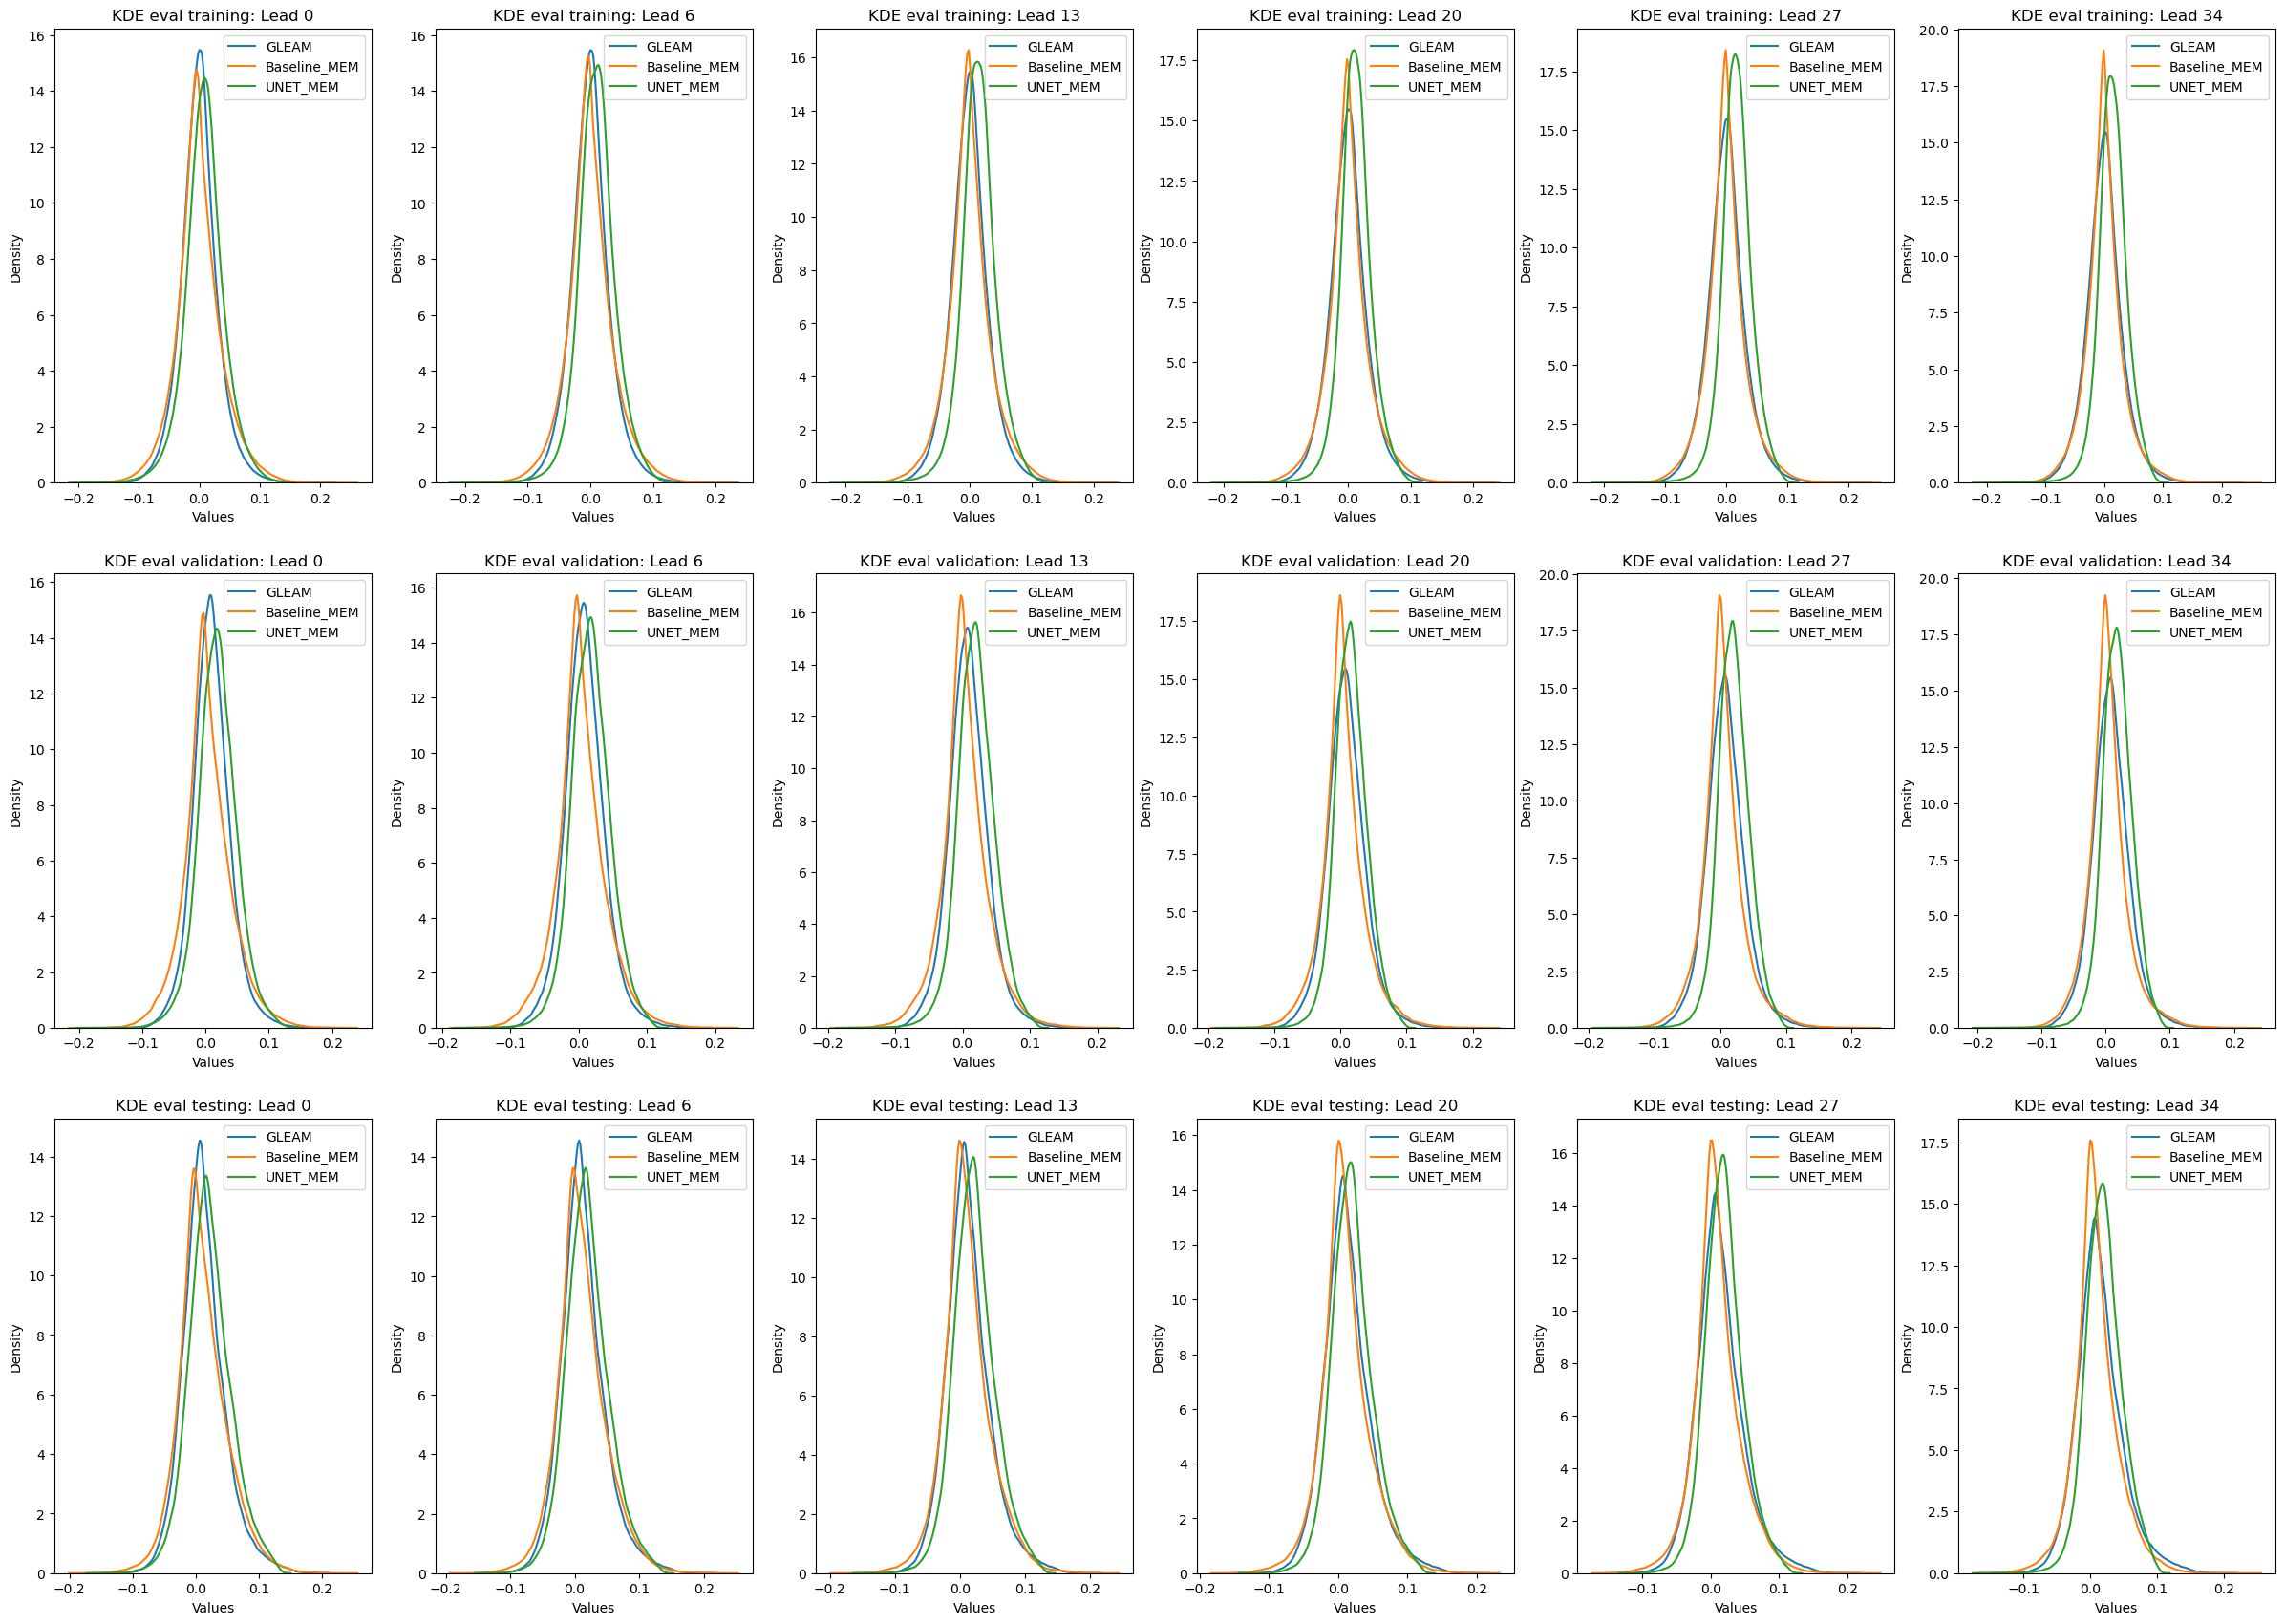

In [167]:


def plot_by_lead_anomaly_distribution():
    save_fig_dir = 'Outputs/anomaly_distribution'
    os.system(f'mkdir -p {save_fig_dir}')

    # Set up the figure and axis
    fig,axs = plt.subplots(nrows=3,ncols=6,figsize=(30, 21))
    axs = axs.flatten()
    idx_plot = 0
    for eval in ['training','validation','testing']:
        for idx,lead in enumerate([0,6,13,20,27,34]):

            if eval == 'training':
                year_start = '2000-01-01'
                year_end = '2015-12-31'
            elif eval == 'validation':
                year_start = '2016-01-01'
                year_end = '2017-12-31'
            else:
                year_start = '2018-01-01'
                year_end = '2019-12-31'
            
            print(f'Working on lead {lead} for eval period {eval}')
            #Options lead = 0, 6, 13, 20, 27, 34
            df = pd.DataFrame({'GLEAM': obs_anomaly_SubX_format.sel(L=lead,S=slice(year_start,year_end)).RZSM.values.flatten(), 'Baseline_MEM': base_anom.sel(L=lead,S=slice(year_start,year_end)).RZSM.values.flatten(), 'UNET_MEM': unet_anom.sel(L=lead,S=slice(year_start,year_end)).RZSM.values.flatten()})
        
            # Plot KDEs for each variable
            for col in df.columns:
                sns.kdeplot(data=df[col], label=col,ax=axs[idx_plot])
            
            # Add labels and title
            axs[idx_plot].set_xlabel('Values')
            axs[idx_plot].set_ylabel('Density')
            axs[idx_plot].set_title(f'KDE eval {eval}: Lead {lead}')
            
            # Add legend
            axs[idx_plot].legend()
            idx_plot+=1
            
    # Show the plot
    plt.savefig(f'{save_fig_dir}/Anomaly_distribution_by_lead.png',bbox_inches='tight')
    plt.show()

plot_by_lead_anomaly_distribution()

In [46]:
#Plot the observation percentiles vs. the other percentiles

### CANNOT MAKE ALL THE PLOTS IN 1 FIGURE, IT'S TOO MEMORY INTENSTVE, SO LET'S JUST DO 1 PLOT AT A TIME

def plot_percentile_by_lead_datashader(lead,baseline_percentile, baseline_percentile_MEM, unet_percentile, unet_percentile_MEM):
    #Compares the reforecast values with the actual observation percentile values
    
    save_dir_plot = 'Outputs/percentile_distribution'
    os.system(f'mkdir -p {save_dir_plot}')
    
    dataset = [baseline_percentile, baseline_percentile_MEM, unet_percentile, unet_percentile_MEM]
    dataset_name = ['Baseline', 'Baseline_MEM', 'UNET', 'UNET_MEM']

    print(f'Lead {lead}')
    
    #Flatten values and select lead for masking    
    obs_subset_MEM = obs_percentile_full.sel(L=lead).mean(dim='M').RZSM_percentile.values.flatten()
    ref_subset_MEM = dataset[1].sel(L=lead).RZSM.values.flatten()
    obs_subset_full_mask_MEM = obs_percentile_full.sel(L=lead).mean(dim='M').RZSM_percentile.values.flatten()
    
    ref_subset_MEM = ref_subset_MEM[~np.isnan(obs_subset_MEM)]
    obs_subset_MEM_mask = ~np.isnan(obs_subset_MEM)
    obs_subset_MEM = obs_subset_MEM[obs_subset_MEM_mask]
    
    obs_subset = obs_percentile_full.sel(L=lead).RZSM_percentile.values.flatten()
    ref_subset = dataset[0].sel(L=lead).RZSM.values.flatten()
    
    obs_subset_full_mask = obs_percentile_full.sel(L=lead).RZSM_percentile.values.flatten()
    print(len(obs_subset_full_mask))
    print(len(obs_subset))
    print(len(ref_subset))
    
    ref_subset= ref_subset[~np.isnan(obs_subset)]
    obs_subset_mask = ~np.isnan(obs_subset)
    obs_subset = obs_subset[~np.isnan(obs_subset)]
    
    print(len(obs_subset))
    print(len(ref_subset))
    
    x_MEM=obs_subset_MEM
    x=obs_subset
    
    y1=dataset[0].sel(L=lead).RZSM.values.flatten()
    print(len(y1))
    print(len(obs_subset_mask))
    print(len(obs_subset_full_mask))
    y1 = y1[~np.isnan(obs_subset_full_mask)]
    
    
    y2=dataset[1].sel(L=lead).RZSM.values.flatten()
    y2 = y2[~np.isnan(obs_subset_full_mask_MEM)]
    
    
    y3=dataset[2].sel(L=lead).RZSM.values.flatten()
    print(len(y3))
    print(len(obs_subset_mask))
    print(len(obs_subset_full_mask))
    
    y3 = y3[~np.isnan(obs_subset_full_mask)]
    
    y4=dataset[3].sel(L=lead).RZSM.values.flatten()
    y4 = y4[~np.isnan(obs_subset_full_mask_MEM)]
    
    # Define the Datashader Canvas
    cvs = ds.Canvas(plot_width=800, plot_height=600)

    # Aggregate the data using Datashader for each subplot
    agg1 = cvs.points(pd.DataFrame({'x': x, 'y': y1}), 'x', 'y')
    agg2 = cvs.points(pd.DataFrame({'x': x_MEM, 'y': y2}), 'x', 'y')
    agg3 = cvs.points(pd.DataFrame({'x': x, 'y': y3}), 'x', 'y')
    agg4 = cvs.points(pd.DataFrame({'x': x_MEM, 'y': y4}), 'x', 'y')

    # Convert the aggregated data to images
    img1 = tfshade.shade(agg1)
    img2 = tfshade.shade(agg2)
    img3 = tfshade.shade(agg3)
    img4 = tfshade.shade(agg4)
    
    # Wrap the images in HoloViews objects
    scatter_plot1 = hv.Image(img1).opts(xlabel='Observation', ylabel=dataset_name[0])
    scatter_plot2 = hv.Image(img2).opts(xlabel='Observation', ylabel=dataset_name[1])
    scatter_plot3 = hv.Image(img3).opts(xlabel='Observation', ylabel=dataset_name[2])
    scatter_plot4 = hv.Image(img4).opts(xlabel='Observation', ylabel=dataset_name[3])

    # Create a layout of subplots
    subplot_layout = (scatter_plot1 + scatter_plot2 + scatter_plot3 + scatter_plot4).cols(4)

    # Save the layout to a PNG file
    hv.save(subplot_layout,  f'{save_dir_plot}/Lead{lead}_percentile_distribution.png')
    
    return(0)

for lead in [0,6,13,20,27,34]:
    plot_percentile_by_lead_datashader(lead=lead,baseline_percentile=baseline_percentile, 
                            baseline_percentile_MEM=baseline_percentile_MEM, 
                            unet_percentile=unet_percentile, unet_percentile_MEM=unet_percentile_MEM)

Lead 0
52867584
52867584
52867584
42863128
42863128
52867584
52867584
52867584
52867584
52867584
52867584


NameError: name 'tf' is not defined

In [48]:
def binary_occurence_smpd(array_,upper_percentile, lower_percentile):
    
    # array_shape = (6, 48, 96)
    
    sm_output = np.zeros_like(array_)
    array_.shape
    
    # i =Y-coords
    for i in range(array_.shape[1]):
        # j = X-coords
        for j in range(array_.shape[2]):
            #we have lead 0,6,13,20,27,34. Don't start with lead 0. Must drop in 3 weeks or less when compared to Day 0. So look at first 3 leads
            for day in range(1,4):
                
                #if rzsm percentile is below the 20th: 
                if array_[day,i,j] <= lower_percentile:
                    
                    #if first week week is greater than 40th: week is in flash drought (1)
                    #1 week code chunk (2 lines below)
                    if (day ==1) and (array_[0,i,j] >= upper_percentile):
                        sm_output[day,i,j] = 1 #flash drought
                    #must drop to below 20th percentile in 3 weeks or less
                    #This is the 3-week code chunk below (next 5 lines)
                    elif (day ==2) and (array_[0,i,j] >= upper_percentile):
                        sm_output[day,i,j] = 1 #flash drought
                    #2 weeks code chunk
                    elif (day ==3) and (array_[0,i,j] >= upper_percentile):
                        sm_output[day,i,j]  = 1 #flash drought   
    return(sm_output)

In [49]:
#Add weeks that are also in flash drought after the first week
#if previous week is in flash drought and the current week is below the 20th percentile
#Then flash drought continues into the future week

def add_days(array_,current_percentile,lower_percentile):
    #shape of array is (6,48,96)
    for i in range(array_.shape[1]):
        for j in range(array_.shape[2]):
            for day in range(2,array_.shape[0]):
                #Start with the 2nd lead (13) because it doesn't make sense for week 1 for this algorithm because if lead 0 is < 20th percentile then flash drought cannot occur
                if array_[day-1,i,j]==1.0 and current_percentile[day,i,j] <=lower_percentile:
                        array_[day,i,j] = 1  
    return(array_)

In [50]:
def findMaxConsecutiveOnes(nums):
    n = len(nums)
    if n == 1 and nums[0] == 1:
        return 1

    res = 0
    c = 0

    for i in range(n):
        if nums[i] == 1:
            c += 1
            res = max(c,res)
        else:
            c = 0 
    return res

def keep_only_if_at_least_2_weeks_length(fd_add_days, length_of_fd):
    fd_add_days.shape
    
    for Y in range(fd_add_days.shape[1]):
        for X in range(fd_add_days.shape[2]):
            #add the mask because it will randomly change the ocean to a value of 1 on lead days
            all_FD_values=[]
            for lead in range(1,fd_add_days.shape[0]):
                all_FD_values.append(fd_add_days[lead,Y,X])

            consecutive_1s=findMaxConsecutiveOnes(nums=all_FD_values)
            #Technially, the first 1 in the series will be the onset, then subsequent ones will be duration
            
            if (consecutive_1s < length_of_fd + 1):
                fd_add_days[:,Y,X] = 0
            else:
                fd_add_days = fd_add_days

    return(fd_add_days)

In [ ]:
def SMPD_OBSERVATIONS_ONLY(obs_percentile_file):
    #test
    # anomaly_file_SubX_format = obs_anomaly_SubX_format
    
    save_dir = 'Data/GLEAM/SMPD'
    os.system(f'mkdir -p {save_dir}')
    smpd_count_by_week_obs = []
    for idx,date in enumerate(obs_percentile_file.S.values):
        # break
        save_name = f'{save_dir}/SMPD_{date}.nc'
        if os.path.exists(save_name):
            pass
        else:
            #The data is structured as SubX format, but we only need a single model becuase they are the same across models
            current_percentile = obs_percentile_file.sel(S=date).isel(M=0).RZSM_percentile.values
            current_percentile.shape
            obs_percentile_full.L.values
            
            output = obs_percentile_file.sel(S=date).copy(deep=True)
            output.RZSM_percentile[:,:,:,:] = 0
            
            blank_file = np.zeros(shape=(obs_percentile_file.sel(S=date).RZSM_percentile.shape))
            blank_file.shape
            fd_1 = binary_occurence_smpd(array_=current_percentile, upper_percentile=40, lower_percentile=20)
            np.count_nonzero(fd_1)
            fd_add_days = add_days(array_=fd_1,current_percentile=current_percentile,lower_percentile=20) #Add days of FD
            np.count_nonzero(fd_add_days)
            fd_add_days =  keep_only_if_at_least_2_weeks_length(fd_add_days = fd_add_days, length_of_fd = 2) #Make sure the FD lasts at least 2 weeks
            np.count_nonzero(fd_add_days)
            blank_file[:,:,:,:] = fd_add_days
            np.count_nonzero(blank_file)
            
            #Now add data back to original dataset
            output.RZSM_percentile[:,:,:,:] =  blank_file[:,:,:,:] 
            output = output.astype(np.int16)
            output = output.expand_dims({'S':1}).rename({'RZSM_percentile':'smpd'})
            
            MEM_count = np.count_nonzero(output.smpd.values)//output.M.shape[0]
            print(f'Total FD weeks:{MEM_count}')
            
            smpd_count_by_week_obs.append(MEM_count)
            
            output.to_netcdf(save_name)
            
            
    return(smpd_count_by_week_obs)


smpd_count_by_week_obs = SMPD_OBSERVATIONS_ONLY(obs_percentile_file=obs_percentile_full)

save_smpd_obs_text = f"Data/GLEAM/SMPD/obs_smpd_count.txt"

if os.path.exists(save_smpd_obs_text):
    # Create an empty list to store the lines
    smpd_count_by_week_obs = []

    # Open file in read mode
    with open(save_smpd_obs_text, "r") as file:
        # Read each line and append to the list
        for line in file:
            smpd_count_by_week_obs.append(int(line.strip()))  # strip() removes leading and trailing whitespaces

else:
    with open(save_smpd_obs_text, "w") as file:
        for item in smpd_count_by_week_obs:
            file.write("%s\n" % item)

smpd_count_by_week_obs

# SMPD on reforecast baseline and prediction
## Requires:
## 1.) Reforecast baseline/prediction percentiles

### We are not using the observation percentiles because they are from a different distribution and it causes the smpd flash drought forecast values to be way overestimated. So we are using the very first day of the prediction (day 0) as the beginning of the forecast

In [78]:
def binary_occurence_smpd_reforecast(array_reforecast_percentile, obs_percentile_val, upper_percentile, lower_percentile):
    
    # array_shape = (6, 48, 96)
    
    sm_output = np.zeros_like(array_reforecast_percentile)
    array_reforecast_percentile.shape
    
    # i =Y-coords
    for i in range(array_reforecast_percentile.shape[1]):
        # j = X-coords
        for j in range(array_reforecast_percentile.shape[2]):
            #we have lead 0,6,13,20,27,34. Don't start with lead 0. Must drop in 3 weeks or less when compared to Day 0. So look at first 3 leads
            for day in range(1,4):
                
                #if rzsm percentile is below the 20th: 
                if array_reforecast_percentile[day,i,j] <= lower_percentile:
                    
                    #if first week week is greater than 40th: week is in flash drought (1)
                    #1 week code chunk (2 lines below)
                    if (day ==1) and (obs_percentile_val[0,i,j] >= upper_percentile):
                        sm_output[day,i,j] = 1 #flash drought
                    #must drop to below 20th percentile in 3 weeks or less
                    #This is the 3-week code chunk below (next 5 lines)
                    elif (day ==2) and (obs_percentile_val[0,i,j] >= upper_percentile):
                        sm_output[day,i,j] = 1 #flash drought
                    #2 weeks code chunk
                    elif (day ==3) and (obs_percentile_val[0,i,j] >= upper_percentile):
                        sm_output[day,i,j]  = 1 #flash drought   
    return(sm_output)

In [79]:


def SMPD_REFORECAST_ONLY(obs_percentile_full, reforecast_percentile_list, reforecast_percentile_MEM_list, save_dir , MEM_or_by_model):
    #test
    os.system(f'mkdir -p {save_dir}')
    
    #Get S values (init dates)
    init_dates = obs_percentile_full.S.values
    
    
    if MEM_or_by_model == 'MEM':
        # open_anomaly_file = xr.open_mfdataset(anomaly_file_list).mean(dim='M')
        # open_percentile_file = xr.open_mfdataset(percentile_file_list_MEM,combine='nested',concat_dim=['S'])
        save_name_m = 'SMPD_MEM'
        reforecast_percentile = reforecast_percentile_MEM_list
        save_smpd_obs_text = f'{save_dir}/smpd_count_MEM.txt'
    else:
        save_name_m = 'SMPD'
        reforecast_percentile = reforecast_percentile_list
        save_smpd_obs_text = f'{save_dir}/smpd_count.txt'

    smpd_count_by_week_obs = []
    for idx,date in enumerate(obs_percentile_full.S.values):
        # break
        save_name = f'{save_dir}/{save_name_m}_{date}.nc'
        percentile_file_to_open = [i for i in reforecast_percentile if date in i][0]
        
        reforecast_percentile_open = xr.open_dataset(percentile_file_to_open)
        
        #blank smpd_file
        smpd = reforecast_percentile_open.copy(deep=True)
        
        if MEM_or_by_model =='MEM':
            smpd.RZSM[:,:,:]=0
        else:
            smpd.RZSM[:,:,:,:]=0
        
        
        if os.path.exists(save_name):
            pass
        else:
            #If percentile is above the 40th to below the 20th in 3 weeks or less, than flash drought begins
            #Always select 1 model from the observations because it's the same data
            obs_percentile_arr = obs_percentile_full.sel(S=date).isel(M=0).RZSM_percentile.values
            
            obs_percentile_arr.shape
            obs_percentile_full.L.values
            
            
            #percentile reforecast array 
            # percentile_arr = reforecast_percentile_open.sel(L=[6,13,20,27,34]).RZSM.values
            # percentile_arr.shape
            
            
            if MEM_or_by_model != 'MEM':
                
                for model in range(reforecast_percentile_open.M.shape[0]):
                    # break
                    reforecast_percentile_run = reforecast_percentile_open.isel(M=model).copy(deep=True).RZSM.values
                    reforecast_percentile_run.shape
                    
                    # break
                    #### We are only using the reforecast percentile as the lead 0 percentile
                    fd_1 = binary_occurence_smpd_reforecast(array_reforecast_percentile = reforecast_percentile_run, obs_percentile_val =reforecast_percentile_run,  upper_percentile=40, lower_percentile=20)
                    np.count_nonzero(fd_1)
                    fd_add_days = add_days(array_=fd_1,current_percentile=reforecast_percentile_run, lower_percentile=20) #Add days of FD
                    np.count_nonzero(fd_add_days)
                    fd_add_days =  keep_only_if_at_least_2_weeks_length(fd_add_days = fd_add_days, length_of_fd = 2) #Make sure the FD lasts at least 2 weeks
                    # print(f'Total FD weeks: {np.count_nonzero(fd_add_days)}')

                    smpd.RZSM[model,:, :, :] = fd_add_days
                    
                smpd = smpd.astype(np.int16).rename({'RZSM':'smpd'}).expand_dims({'S':1})
                print(f'Total FD weeks of all ensemble realizations: {np.count_nonzero(smpd.smpd.values)}')
                smpd_count_by_week_obs.append(np.count_nonzero(smpd.smpd.values))
                smpd.to_netcdf(save_name)
            
            else:
                reforecast_percentile_run = reforecast_percentile_open.copy(deep=True).RZSM.values
                reforecast_percentile_run.shape
                #### We are only using the reforecast percentile as the lead 0 percentile
                fd_1 = binary_occurence_smpd_reforecast(array_reforecast_percentile = reforecast_percentile_run, obs_percentile_val =reforecast_percentile_run,  upper_percentile=40, lower_percentile=20)
                np.count_nonzero(fd_1)
                fd_add_days = add_days(array_=fd_1,current_percentile=reforecast_percentile_run, lower_percentile=20) #Add days of FD
                np.count_nonzero(fd_add_days)
                fd_add_days =  keep_only_if_at_least_2_weeks_length(fd_add_days = fd_add_days, length_of_fd = 2) #Make sure the FD lasts at least 2 weeks
                # print(f'Total FD weeks: {np.count_nonzero(fd_add_days)}')

                smpd.RZSM[:, :, :] = fd_add_days
                smpd = smpd.astype(np.int16).rename({'RZSM':'smpd'}).expand_dims({'S':1})
                print(f'Total FD weeks of all MEM: {np.count_nonzero(smpd.smpd.values)}')
                smpd_count_by_week_obs.append(np.count_nonzero(smpd.smpd.values))
                smpd.to_netcdf(save_name)

    if os.path.exists(save_smpd_obs_text):
        # Create an empty list to store the lines
        smpd_count_by_week_obs = []

        # Open file in read mode
        with open(save_smpd_obs_text, "r") as file:
            # Read each line and append to the list
            for line in file:
                smpd_count_by_week_obs.append(int(line.strip()))  # strip() removes leading and trailing whitespaces
    else:
        with open(save_smpd_obs_text, "w") as file:
            for item in smpd_count_by_week_obs:
                file.write("%s\n" % item)
            
    return(smpd_count_by_week_obs)


In [80]:
#Baseline reforecast data
base_smpd_count = SMPD_REFORECAST_ONLY(obs_percentile_full=obs_percentile_full, 
                     reforecast_percentile_list=baseline_percentile_file_list, 
                     reforecast_percentile_MEM_list=baseline_percentile_MEM_file_list,
                     save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMPD',
                     MEM_or_by_model='model_realization')

#Baseline reforecast data
base_smpd_count_MEM = SMPD_REFORECAST_ONLY(obs_percentile_full=obs_percentile_full, 
                     reforecast_percentile_list=baseline_percentile_file_list, 
                     reforecast_percentile_MEM_list=baseline_percentile_MEM_file_list,
                     save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMPD',
                     MEM_or_by_model='MEM')

Total FD weeks of all ensemble realizations: 5736
Total FD weeks of all ensemble realizations: 2516
Total FD weeks of all ensemble realizations: 523
Total FD weeks of all ensemble realizations: 326
Total FD weeks of all ensemble realizations: 1379
Total FD weeks of all ensemble realizations: 2979
Total FD weeks of all ensemble realizations: 8184
Total FD weeks of all ensemble realizations: 12142
Total FD weeks of all ensemble realizations: 10273
Total FD weeks of all ensemble realizations: 7465
Total FD weeks of all ensemble realizations: 3082
Total FD weeks of all ensemble realizations: 7776
Total FD weeks of all ensemble realizations: 2329
Total FD weeks of all ensemble realizations: 2923
Total FD weeks of all ensemble realizations: 2817
Total FD weeks of all ensemble realizations: 5391
Total FD weeks of all ensemble realizations: 4879
Total FD weeks of all ensemble realizations: 5203
Total FD weeks of all ensemble realizations: 4591
Total FD weeks of all ensemble realizations: 3371


In [ ]:
#check some values for smpd count
smpd_count_by_week_obs[0:10]
base_smpd_count[0:10]
base_smpd_count_MEM[0:10]

In [81]:
#UNET prediction reforecast data
unet_smpd_count = SMPD_REFORECAST_ONLY(obs_percentile_full=obs_percentile_full, 
                     reforecast_percentile_list=unet_percentile_file_list, 
                     reforecast_percentile_MEM_list=unet_percentile_MEM_file_list,
                     save_dir=f'predictions/UNET/SMPD/{experiment_name}',
                     MEM_or_by_model='model_realization')

#UNET prediction reforecast data
unet_smpd_MEM_count = SMPD_REFORECAST_ONLY(obs_percentile_full=obs_percentile_full, 
                     reforecast_percentile_list=unet_percentile_file_list, 
                     reforecast_percentile_MEM_list=unet_percentile_MEM_file_list,
                      save_dir=f'predictions/UNET/SMPD/{experiment_name}',
                     MEM_or_by_model='MEM')

Total FD weeks of all ensemble realizations: 68
Total FD weeks of all ensemble realizations: 51
Total FD weeks of all ensemble realizations: 79
Total FD weeks of all ensemble realizations: 72
Total FD weeks of all ensemble realizations: 72
Total FD weeks of all ensemble realizations: 55
Total FD weeks of all ensemble realizations: 119
Total FD weeks of all ensemble realizations: 207
Total FD weeks of all ensemble realizations: 191
Total FD weeks of all ensemble realizations: 256
Total FD weeks of all ensemble realizations: 322
Total FD weeks of all ensemble realizations: 301
Total FD weeks of all ensemble realizations: 179
Total FD weeks of all ensemble realizations: 262
Total FD weeks of all ensemble realizations: 53
Total FD weeks of all ensemble realizations: 135
Total FD weeks of all ensemble realizations: 150
Total FD weeks of all ensemble realizations: 148
Total FD weeks of all ensemble realizations: 69
Total FD weeks of all ensemble realizations: 120
Total FD weeks of all ensemb

In [ ]:
smpd_count_by_week_obs[0:10]
unet_smpd_count[0:10]
unet_smpd_MEM_count[0:10]

# Now plot the data for different indexes

In [168]:
# del obs_percentile_full

############### FIRST LOAD ALL THE DATA, THEY ARE SMALLER FILES ####################################################################

#Open observation files
obs_smpd = xr.open_mfdataset('Data/GLEAM/SMPD/SMPD*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
np.count_nonzero(obs_smpd.smpd[:,:,-1,:,:].values)


#Reforecast baseline files
baseline_reforecast_smpd = xr.open_mfdataset('Data/GEFSv12_reforecast/soilw_bgrnd/SMPD/SMPD_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
baseline_reforecast_smpd_MEM = xr.open_mfdataset('Data/GEFSv12_reforecast/soilw_bgrnd/SMPD/SMPD_MEM_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
np.count_nonzero(baseline_reforecast_smpd.smpd[:,:,-1,:,:].values)

#Prediction (UNET) files
unet_prediction_SMPD = xr.open_mfdataset(f'predictions/UNET/SMPD/{experiment_name}/SMPD_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()
unet_prediction_SMPD_MEM = xr.open_mfdataset(f'predictions/UNET/SMPD/{experiment_name}/SMPD_MEM_2*.nc',combine='nested',concat_dim=['S']).sel(L=[6,13,20,27,34]).load()

np.count_nonzero(unet_prediction_SMPD.smpd[:,:,-1,:,:].values)

def check_counts_by_lead(lead):
    print('\n')
    print(f'Lead {lead+1}')
    print(f'Observation across all models, inits, lat/lon: {np.count_nonzero(obs_smpd.smpd[:,:,lead,:,:].values)}')
    print(f'Baseline reforecast across all models, inits, lat/lon: {np.count_nonzero(baseline_reforecast_smpd.smpd[:,:,lead,:,:].values)}')
    print(f'UNET prediction across all models, inits, lat/lon: {np.count_nonzero(unet_prediction_SMPD.smpd[:,:,lead,:,:].values)}')
    print('\n')
    return()

for lead in range(5):
    check_counts_by_lead(lead)
#Test
# anomaly_file_list=baseline_anomaly_file_list
# percentile_file_list = baseline_percentile_file_list
# percentile_file_list_MEM=baseline_percentile_MEM_file_list
# obs_anomaly=obs_anomaly
# save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMVI'
# MEM_or_by_model='MEM'

CONUS_mask_arr = CONUS_mask.to_array().values.squeeze().squeeze()



Lead 1
Observation across all models, inits, lat/lon: 137709
Baseline reforecast across all models, inits, lat/lon: 35201
UNET prediction across all models, inits, lat/lon: 104679




Lead 2
Observation across all models, inits, lat/lon: 382921
Baseline reforecast across all models, inits, lat/lon: 631862
UNET prediction across all models, inits, lat/lon: 274806




Lead 3
Observation across all models, inits, lat/lon: 703461
Baseline reforecast across all models, inits, lat/lon: 1373839
UNET prediction across all models, inits, lat/lon: 292791




Lead 4
Observation across all models, inits, lat/lon: 659791
Baseline reforecast across all models, inits, lat/lon: 1365429
UNET prediction across all models, inits, lat/lon: 254376




Lead 5
Observation across all models, inits, lat/lon: 556347
Baseline reforecast across all models, inits, lat/lon: 1212498
UNET prediction across all models, inits, lat/lon: 25232




In [169]:
#CONSTRUCT TRUE POSITIVE, FALSE POSITIVE, FALSE NEGATIVE INFO

def metric_MEM(reforecast_file, observation_file, save_dir):
    os.system(f'mkdir -p {save_dir}')
    #test 
    # reforecast_file = unet_prediction_SMPD_MEM
    # observation_file = obs_smpd
    # save_dir = f'predictions/UNET/SMVI/{experiment_name}'
    
    #Returns the CSI (critical success index metric, true positive rate, and false positive rate)
    csi_out = reforecast_file.isel(S=0).copy(deep=True)
    csi_out.smpd[:,:,:] = 0
    csi_out = csi_out.astype(np.float32)
    
    tpr_out = reforecast_file.isel(S=0).copy(deep=True)
    tpr_out.smpd[:,:,:] = 0
    tpr_out = tpr_out.astype(np.float32)
    
    fpr_out = reforecast_file.isel(S=0).copy(deep=True)
    fpr_out.smpd[:,:,:] = 0
    fpr_out = fpr_out.astype(np.float32)
    
    observation_file = observation_file.mean(dim='M')
    
    #only choose warm season months (March - November)
    reforecast_file_subset = reforecast_file.sel(S=reforecast_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(reforecast_file_subset.smpd.values)
    
    observation_file = observation_file.assign_coords(S=reforecast_file.S.values)
    
    observation_file_subset = observation_file.sel(S=observation_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(observation_file_subset.smpd.values)

    #True positive
    tp = np.where((observation_file_subset.smpd.values == 1) & (reforecast_file_subset.smpd.values == 1),1,0) 
    np.count_nonzero(tp)
    tp.shape
    np.count_nonzero(np.isnan(tp))

    #False positive
    fp = np.where((observation_file_subset.smpd.values == 0) & (reforecast_file_subset.smpd.values == 1),1,0) 
    np.count_nonzero(fp)
    
    fn = np.where((observation_file_subset.smpd.values == 1) & (reforecast_file_subset.smpd.values == 0),1,0) 
    np.count_nonzero(fn)

    tn = np.where((observation_file_subset.smpd.values == 0) & (reforecast_file_subset.smpd.values == 0),1,0) 
    np.count_nonzero(tn)

    tp_sum = tp.sum(axis=0)
    fp_sum = fp.sum(axis=0)
    fn_sum = fn.sum(axis=0)
    tn_sum = tn.sum(axis=0)
    
    
    TPR = (tp_sum/(tp_sum+fn_sum))*100
    tpr_out.smpd[:,:,:] = TPR
    len(np.unique(tpr_out.smpd.values))
    
    FPR = (fp_sum/(fp_sum+tn_sum))*100
    fpr_out.smpd[:,:,:] = FPR
    len(np.unique(fpr_out.smpd.values))
    
    CSI = (tp_sum/(tp_sum+fp_sum+fn_sum))*100
    csi_out.smpd[:,:,:] = CSI
    len(np.unique(csi_out.smpd.values))

    
    #We could apply numpy where functions, but it's easier just to explicitly loop through data
    for X in range(reforecast_file_subset.X.shape[0]):
        # print(X)
        for Y in range(reforecast_file_subset.Y.shape[0]):
            if CONUS_mask_arr[Y,X] == 1:

                csi_out.smpd[:,Y,X] = np.nan
                fpr_out.smpd[:,Y,X] = np.nan
                tpr_out.smpd[:,Y,X] = np.nan
    
    #Now save the data
    csi_out.to_netcdf(f'{save_dir}/csi_percentage_MEM.nc')
    tpr_out.to_netcdf(f'{save_dir}/tpr_percentage_MEM.nc')
    fpr_out.to_netcdf(f'{save_dir}/fpr_percentage_MEM.nc')
            
                    
                

In [170]:
# Run the different metrics across CONUS for MEM
metric_MEM(reforecast_file=baseline_reforecast_smpd_MEM, observation_file=obs_smpd, save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMPD/metric_values')
metric_MEM(reforecast_file=unet_prediction_SMPD_MEM, observation_file=obs_smpd, save_dir=f'predictions/UNET/SMPD/{experiment_name}/metric_values')

/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/4291264046.py:56: RuntimeWarning: invalid value encountered in divide
  TPR = (tp_sum/(tp_sum+fn_sum))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/4291264046.py:64: RuntimeWarning: invalid value encountered in divide
  CSI = (tp_sum/(tp_sum+fp_sum+fn_sum))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/4291264046.py:56: RuntimeWarning: invalid value encountered in divide
  TPR = (tp_sum/(tp_sum+fn_sum))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/4291264046.py:64: RuntimeWarning: invalid value encountered in divide
  CSI = (tp_sum/(tp_sum+fp_sum+fn_sum))*100


In [173]:
#CONSTRUCT TRUE POSITIVE, FALSE POSITIVE, FALSE NEGATIVE INFO

def metric_ensemble_realization_probability(reforecast_file, observation_file, save_dir, probability):
    
    #test for 
    # reforecast_file = unet_prediction_SMPD_MEM
    # observation_file = obs_smpd
    # save_dir = f'predictions/UNET/SMVI/{experiment_name}'

    #There are 11 different model realizations, so just assume 10 models for probability sake

    os.system(f'mkdir -p {save_dir}')
    
    #Returns the CSI (critical success index metric, true positive rate, and false positive rate)
    csi_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    csi_out.smpd[:,:,:] = 0
    csi_out = csi_out.astype(np.float32)
    
    tpr_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    tpr_out.smpd[:,:,:] = 0
    tpr_out = tpr_out.astype(np.float32)
    
    fpr_out = reforecast_file.isel(S=0).mean(dim='M').copy(deep=True)
    fpr_out.smpd[:,:,:] = 0
    fpr_out = fpr_out.astype(np.float32)
        
    #only choose warm season months (March - November)
    reforecast_file_subset = reforecast_file.sel(S=reforecast_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(reforecast_file_subset.smpd.values)
    
    observation_file = observation_file.assign_coords(S=reforecast_file.S.values)
    
    observation_file_subset = observation_file.sel(S=observation_file['S.month'].isin([3,4,5,6,7,8,9,10,11]))
    np.count_nonzero(observation_file_subset.smpd.values)
    
    #True positive
    tp = np.where((observation_file_subset.smpd.values == 1) & (reforecast_file_subset.smpd.values == 1),1,0) 
    np.count_nonzero(tp)
    tp.shape
    np.count_nonzero(np.isnan(tp))

    #False positive
    fp = np.where((observation_file_subset.smpd.values == 0) & (reforecast_file_subset.smpd.values == 1),1,0) 
    np.count_nonzero(fp)
    
    fn = np.where((observation_file_subset.smpd.values == 1) & (reforecast_file_subset.smpd.values == 0),1,0) 
    np.count_nonzero(fn)

    tn = np.where((observation_file_subset.smpd.values == 0) & (reforecast_file_subset.smpd.values == 0),1,0) 
    np.count_nonzero(tn)
    
    #Now only sum over the model realization and see if the probability exceeds it
    tp_sum_prob = np.where(tp.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    tp_sum_prob.shape
    fp_sum_prob = np.where(fp.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    fn_sum_prob = np.where(fn.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    tn_sum_prob = np.where(tn.sum(axis=1) >= probability*10,1,0).sum(axis=0)
    
    
    TPR = (tp_sum_prob/(tp_sum_prob+fn_sum_prob))*100
    tpr_out.smpd[:,:,:] = TPR
    len(np.unique(tpr_out.smpd.values))
    
    FPR = (fp_sum_prob/(fp_sum_prob+tn_sum_prob))*100
    fpr_out.smpd[:,:,:] = FPR
    len(np.unique(fpr_out.smpd.values))
    
    CSI = (tp_sum_prob/(tp_sum_prob+fp_sum_prob+fn_sum_prob))*100
    csi_out.smpd[:,:,:] = CSI
    len(np.unique(csi_out.smpd.values))

    
    #We could apply numpy where functions, but it's easier just to explicitly loop through data
    for X in range(reforecast_file_subset.X.shape[0]):
        # print(X)
        for Y in range(reforecast_file_subset.Y.shape[0]):
            if CONUS_mask_arr[Y,X] == 1:

                csi_out.smpd[:,Y,X] = np.nan
                fpr_out.smpd[:,Y,X] = np.nan
                tpr_out.smpd[:,Y,X] = np.nan
    
    #Now save the data
    csi_out.to_netcdf(f'{save_dir}/csi_percentage_probability{probability}.nc')
    tpr_out.to_netcdf(f'{save_dir}/tpr_percentage_probability{probability}.nc')
    fpr_out.to_netcdf(f'{save_dir}/fpr_percentage_probability{probability}.nc')
            
                    
                

In [174]:
# Run the different metrics across CONUS for MEM
metric_ensemble_realization_probability(reforecast_file=baseline_reforecast_smpd, observation_file=obs_smpd, save_dir='Data/GEFSv12_reforecast/soilw_bgrnd/SMPD/metric_values', probability = 0.5)
metric_ensemble_realization_probability(reforecast_file=unet_prediction_SMPD, observation_file=obs_smpd, save_dir=f'predictions/UNET/SMPD/{experiment_name}/metric_values', probability = 0.5)

/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/3042509303.py:60: RuntimeWarning: invalid value encountered in divide
  TPR = (tp_sum_prob/(tp_sum_prob+fn_sum_prob))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/3042509303.py:68: RuntimeWarning: invalid value encountered in divide
  CSI = (tp_sum_prob/(tp_sum_prob+fp_sum_prob+fn_sum_prob))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/3042509303.py:60: RuntimeWarning: invalid value encountered in divide
  TPR = (tp_sum_prob/(tp_sum_prob+fn_sum_prob))*100
/glade/derecho/scratch/klesinger/tmp/ipykernel_63162/3042509303.py:68: RuntimeWarning: invalid value encountered in divide
  CSI = (tp_sum_prob/(tp_sum_prob+fp_sum_prob+fn_sum_prob))*100
